### This script estimates pv production of a residential location based on its solar panel detection results.

In [3]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

Implementation:  
- read detection resuults from address.txt


(561, 558)


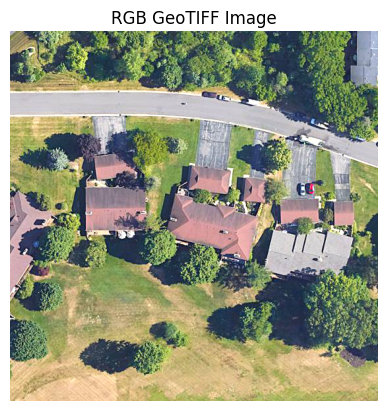

In [16]:
def visualize_geotiff_rgb(filepath):
    """
    Visualize a GeoTIFF file as an RGB image, assuming the file has no extension but contains at least three bands.
    
    Args:
    filepath (str): Path to the GeoTIFF file without the extension.
    
    Raises:
    FileNotFoundError: If the file cannot be found or read.
    ValueError: If the file does not contain at least three bands.
    """
    try:
        with rasterio.open(filepath) as src:
            # Check if there are at least three bands
            if src.count < 3:
                raise ValueError("GeoTIFF file does not contain enough bands for RGB visualization (requires at least 3 bands).")
            print(src.shape)
            # Read the first three bands (Red, Green, Blue)
            red = src.read(1)
            green = src.read(2)
            blue = src.read(3)
            
            # Stack bands
            rgb = np.dstack((red, green, blue))
            
    except rasterio.errors.RasterioIOError as e:
        raise FileNotFoundError(f"Unable to locate or read the file at {filepath}") from e

    # Normalize the bands to (0, 1) for plotting
    rgb_normalized = rgb.astype('float32')
    max_val = np.percentile(rgb, 99)
    rgb_normalized /= max_val

    # Clip values to the range [0, 1]
    rgb_normalized = np.clip(rgb_normalized, 0, 1)

    # Plotting the data
    plt.imshow(rgb_normalized)
    plt.title('RGB GeoTIFF Image')
    plt.axis('off')  # Hide axes
    plt.show()

# Example usage
visualize_geotiff_rgb('/home/psc/Desktop/solarRec/test_data/6200_Tahoe_Dr_SE,_Grand_Rapids,_MI_49546/jpg_6200_Tahoe_Dr_SE,_Grand_Rapids,_MI_49546.jpg')

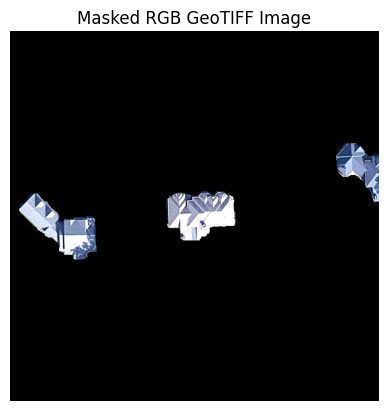

In [33]:
def visualize_geotiff_maskedRGB(filepath, maskpath):
    """
    Visualize a masked RGB GeoTIFF image where the mask highlights certain areas (e.g., rooftops).

    Args:
    filepath (str): Path to the RGB GeoTIFF file.
    maskpath (str): Path to the binary mask GeoTIFF file.

    Raises:
    FileNotFoundError: If the file cannot be found or read.
    ValueError: If the RGB file does not contain at least three bands.
    """
    try:
        with rasterio.open(filepath) as src, rasterio.open(maskpath) as mask_src:
            # Check if there are at least three bands
            if src.count < 3:
                raise ValueError("GeoTIFF file does not contain enough bands for RGB visualization (requires at least 3 bands).")

            # Read the first three bands (Red, Green, Blue)
            red = src.read(1)
            green = src.read(2)
            blue = src.read(3)
            
            # Read mask
            mask = mask_src.read(1)

            # Apply the mask to each RGB band
            red_masked = np.where(mask == 1, red, 0)
            green_masked = np.where(mask == 1, green, 0)
            blue_masked = np.where(mask == 1, blue, 0)

            # Stack masked bands
            rgb_masked = np.dstack((red_masked, green_masked, blue_masked))

    except rasterio.errors.RasterioIOError as e:
        raise FileNotFoundError(f"Unable to locate or read the file at {filepath}") from e

    # Normalize the bands to (0, 1) for plotting
    rgb_normalized = rgb_masked.astype('float32')
    max_val = np.percentile(rgb_masked, 99)
    rgb_normalized /= max_val

    # Clip values to the range [0, 1]
    rgb_normalized = np.clip(rgb_normalized, 0, 1)

    # Plotting the data
    plt.imshow(rgb_normalized)
    plt.title('Masked RGB GeoTIFF Image')
    plt.axis('off')  # Hide axes
    plt.show()
# Example usage
img_path = '/home/psc/Desktop/solarRec/test_data/1099_Skyevale_NE,_Ada,_MI_49301/jpg_1099_Skyevale_NE,_Ada,_MI_49301.jpg'
mask_path = '/home/psc/Desktop/solarRec/test_data/1099_Skyevale_NE,_Ada,_MI_49301/mask_1099_Skyevale_NE,_Ada,_MI_49301.tif'
visualize_geotiff_maskedRGB(img_path, mask_path)

/home/psc/miniconda3/envs/solarRec/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


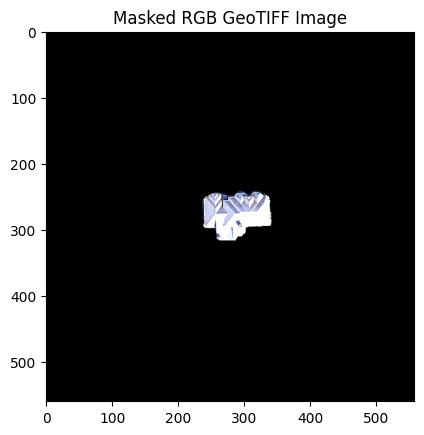

In [34]:
import cv2
def find_main_mask(mask_path):
    """
    Finds the contour closest to the center of the image from a binary mask and returns a mask with only that contour.

    Args:
    mask_path (str): Path to the binary mask GeoTIFF file.

    Returns:
    np.ndarray: A mask with the closest contour to the center of the image filled.
    """
    with rasterio.open(mask_path) as src:
        mask = src.read(1)
        mask_bin = np.uint8(mask * 255)

    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_center = np.array([src.width / 2, src.height / 2])
    min_dist = np.inf
    closest_contour = None

    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroid = np.array([cx, cy])
            dist = np.linalg.norm(centroid - image_center)
            if dist < min_dist:
                min_dist = dist
                closest_contour = contour

    # Create a blank mask and draw the closest contour filled
    closest_contour_mask = np.zeros_like(mask)
    cv2.drawContours(closest_contour_mask, [closest_contour], -1, (1), thickness=cv2.FILLED)

    return closest_contour_mask

def visualize_geotiff_maskedRGB_2(filepath, mask):
    """
    Visualize a masked RGB GeoTIFF image where the mask highlights certain areas (e.g., rooftops).

    Args:
    filepath (str): Path to the RGB GeoTIFF file.
    maskpath (str): Path to the binary mask GeoTIFF file.

    Raises:
    FileNotFoundError: If the file cannot be found or read.
    ValueError: If the RGB file does not contain at least three bands.
    """
    try:
        with rasterio.open(filepath) as src:
            # Check if there are at least three bands
            if src.count < 3:
                raise ValueError("GeoTIFF file does not contain enough bands for RGB visualization (requires at least 3 bands).")

            # Read the first three bands (Red, Green, Blue)
            red = src.read(1)
            green = src.read(2)
            blue = src.read(3)
            
            # Read mask

            # Apply the mask to each RGB band
            red_masked = np.where(mask == 1, red, 0)
            green_masked = np.where(mask == 1, green, 0)
            blue_masked = np.where(mask == 1, blue, 0)

            # Stack masked bands
            rgb_masked = np.dstack((red_masked, green_masked, blue_masked))

    except rasterio.errors.RasterioIOError as e:
        raise FileNotFoundError(f"Unable to locate or read the file at {filepath}") from e

    # Normalize the bands to (0, 1) for plotting
    rgb_normalized = rgb_masked.astype('float32')
    max_val = np.percentile(rgb_masked, 99)
    rgb_normalized /= max_val

    # Clip values to the range [0, 1]
    rgb_normalized = np.clip(rgb_normalized, 0, 1)

    # Plotting the data
    plt.imshow(rgb_normalized)
    plt.title('Masked RGB GeoTIFF Image')
    plt.axis('on')
    plt.show()

mask_path = '/home/psc/Desktop/solarRec/test_data/1099_Skyevale_NE,_Ada,_MI_49301/mask_1099_Skyevale_NE,_Ada,_MI_49301.tif'
processed_mask = find_main_mask(mask_path)
visualize_geotiff_maskedRGB_2(img_path, processed_mask)


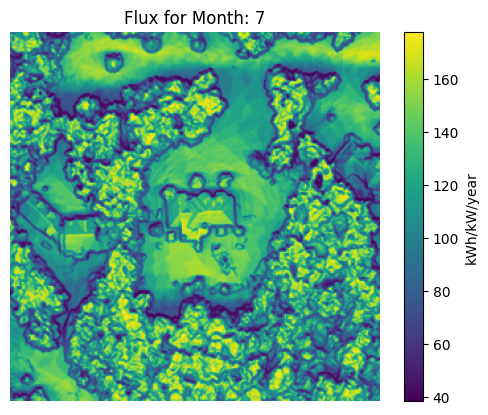

In [35]:
import rasterio
import matplotlib.pyplot as plt

def visualize_monthly_flux(filepath, month):
    """
    Visualize a specific month's flux from a GeoTIFF file with 12 bands, each representing a different month.

    Args:
    filepath (str): Path to the GeoTIFF file.
    month (int): Month to visualize (1 for January, 2 for February, ..., 12 for December).

    Raises:
    FileNotFoundError: If the file cannot be found or read.
    ValueError: If the specified month is not valid or the file does not contain 12 bands.
    """
    if month < 1 or month > 12:
        raise ValueError("Invalid month. Please choose a value between 1 and 12.")
    
    try:
        with rasterio.open(filepath) as src:
            if src.count != 12:
                raise ValueError("The GeoTIFF file does not contain 12 bands, as required for monthly data.")

            # Read the band corresponding to the specified month
            data = src.read(month)  # Month 1 corresponds to band 1, and so on

            # Normalize the data for better visualization
            vmin, vmax = data.min(), data.max()
            plt.imshow(data, cmap='viridis', vmin=vmin, vmax=vmax)
            plt.colorbar(label='kWh/kW/year')
            plt.title(f'Flux for Month: {month}')
            plt.axis('off')
            plt.show()

    except rasterio.errors.RasterioIOError as e:
        raise FileNotFoundError(f"Unable to locate or read the file at {filepath}") from e

monthlyFlux_path = '/home/psc/Desktop/solarRec/test_data/1099_Skyevale_NE,_Ada,_MI_49301/monthlyFlux_1099_Skyevale_NE,_Ada,_MI_49301.tif'
month = 7
visualize_monthly_flux(monthlyFlux_path, month)